In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


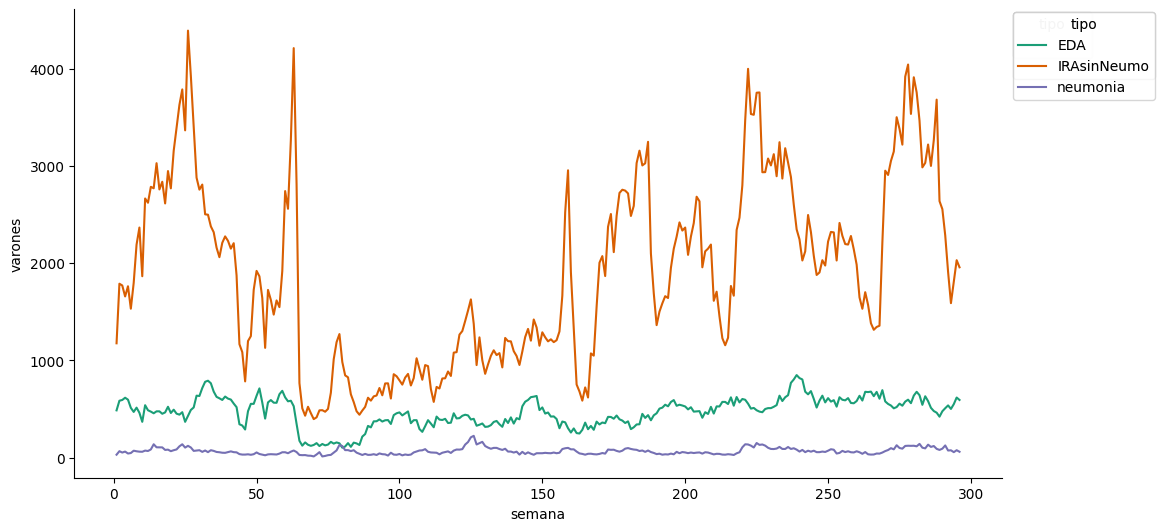

In [ ]:
# @title semana vs varones

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['semana']
  ys = series['varones']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('semana', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tipo')):
  _plot_series(series, series_name, i)
  fig.legend(title='tipo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('semana')
_ = plt.ylabel('varones')

In [ ]:
# Filtrar los datos para Neumonía en varones y preparar el formato
data_neumonia_varones = data[data['tipo'] == 'neumonia'][['fecha', 'varones']]
data_neumonia_varones['fecha'] = pd.to_datetime(data_neumonia_varones['fecha'], dayfirst=True)
data_neumonia_varones = data_neumonia_varones.sort_values(by='fecha')
data_neumonia_varones.set_index('fecha', inplace=True)

# Prueba de Dickey-Fuller para verificar estacionaridad
result_neumonia_varones = adfuller(data_neumonia_varones['varones'])
print('Prueba de Dickey-Fuller para Neumonía - Varones:')
print(f'Estadístico de prueba: {result_neumonia_varones[0]:.4f}')
print(f'P-valor: {result_neumonia_varones[1]:.4f}')
for key, value in result_neumonia_varones[4].items():
    print(f'Valor Crítico {key}: {value:.4f}')

Prueba de Dickey-Fuller para Neumonía - Varones:
Estadístico de prueba: -4.7837
P-valor: 0.0001
Valor Crítico 1%: -3.4527
Valor Crítico 5%: -2.8714
Valor Crítico 10%: -2.5720


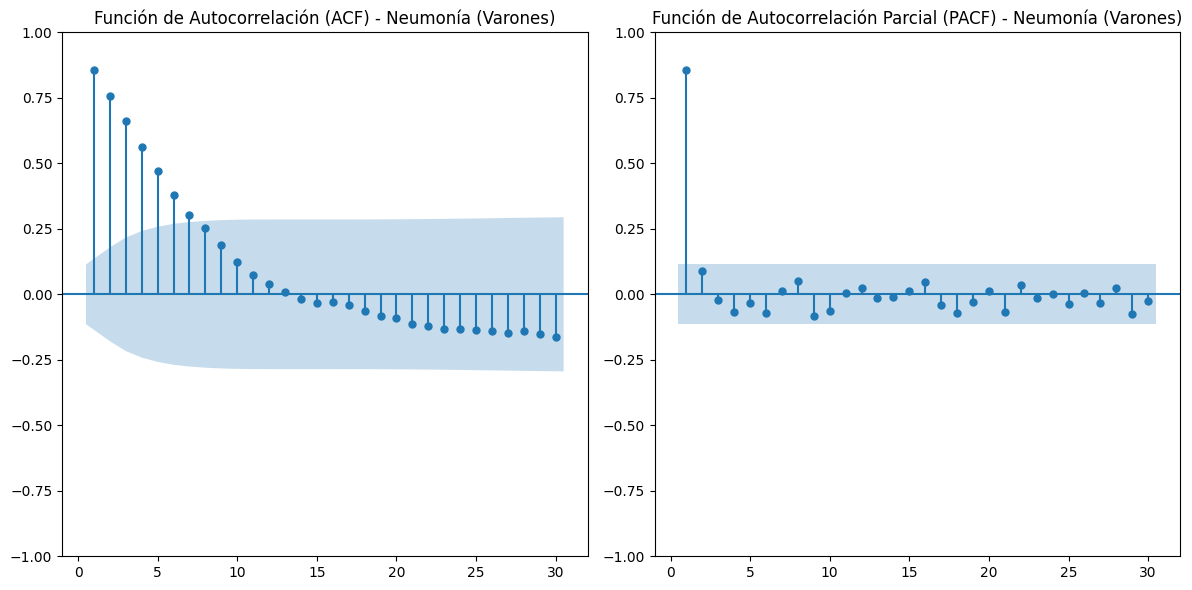

In [ ]:
# Graficar ACF y PACF de la serie de Neumonía en varones
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data_neumonia_varones['varones'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF) - Neumonía (Varones)")

plt.subplot(1, 2, 2)
plot_pacf(data_neumonia_varones['varones'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF) - Neumonía (Varones)")

plt.tight_layout()
plt.show()

In [ ]:
# Configurar y ajustar el modelo ARIMA
model_arima_neumonia_varones = ARIMA(data_neumonia_varones, order=(1, 0, 1))
arima_result_neumonia_varones = model_arima_neumonia_varones.fit()

# Mostrar el resumen del modelo
print(arima_result_neumonia_varones.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                varones   No. Observations:                  296
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1259.719
Date:                Tue, 03 Dec 2024   AIC                           2527.439
Time:                        15:08:45   BIC                           2542.200
Sample:                    01-07-2019   HQIC                          2533.349
                         - 09-02-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.5579      8.881      7.382      0.000      48.151      82.965
ar.L1          0.8800      0.026     33.365      0.000       0.828       0.932
ma.L1         -0.0860      0.063     -1.360      0.1

In [ ]:
# Dividir en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(data_neumonia_varones) * 0.85)
train_neumonia_varones = data_neumonia_varones[:train_size]
test_neumonia_varones = data_neumonia_varones[train_size:]

# Realizar predicciones en el conjunto de prueba
predictions_arima_neumonia_varones = arima_result_neumonia_varones.predict(start=len(train_neumonia_varones),
                                                                           end=len(data_neumonia_varones)-1, typ='levels')

# Calcular métricas de evaluación
y_true = test_neumonia_varones['varones'].values
y_pred = predictions_arima_neumonia_varones.values

mae_arima = mean_absolute_error(y_true, y_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))
mape_arima = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convertir a porcentaje
smape_arima = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_arima:.2f}')
print(f'RMSE: {rmse_arima:.2f}')
print(f'MAPE: {mape_arima:.2f}%')
print(f'sMAPE: {smape_arima:.2f}%')

MAE: 14.90
RMSE: 18.90
MAPE: 20.21%
sMAPE: 19.29%


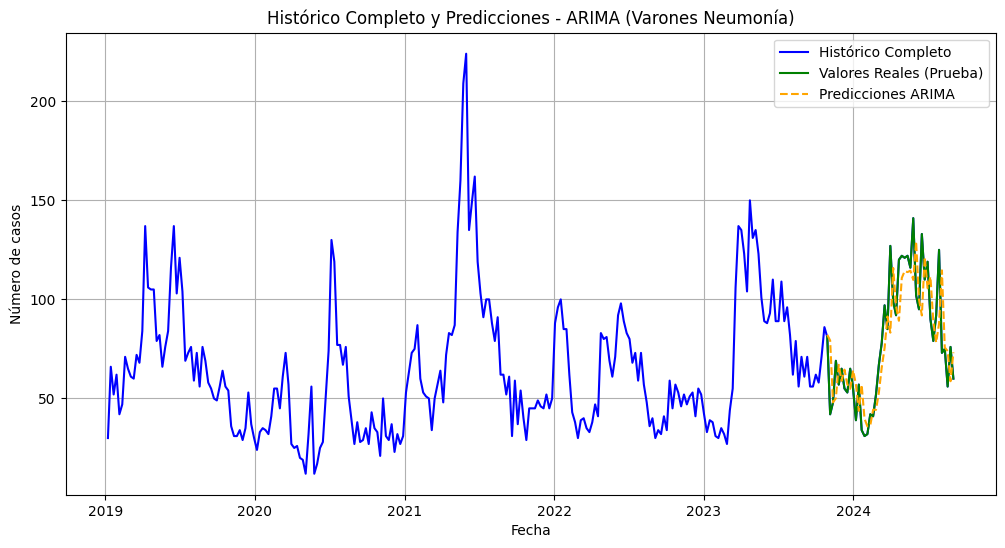

In [ ]:
# Graficar el histórico y las predicciones del modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_varones.index, data_neumonia_varones['varones'], label="Histórico Completo", color="blue")
plt.plot(test_neumonia_varones.index, y_true, label="Valores Reales (Prueba)", color="green")
plt.plot(test_neumonia_varones.index, y_pred, color='orange', linestyle='--', label="Predicciones ARIMA")
plt.title("Histórico Completo y Predicciones - ARIMA (Varones Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para ARIMA
comparison_df_arima_neumonia_varones = pd.DataFrame({
    'Fecha': test_neumonia_varones.index,
    'Valores Reales': y_true,
    'Predicciones ARIMA': y_pred
})

# Mostrar el DataFrame comparativo
print(comparison_df_arima_neumonia_varones)

        Fecha  Valores Reales  Predicciones ARIMA
0  2023-10-30              81           82.113542
1  2023-11-06              42           79.242094
2  2023-11-13              48           48.029753
3  2023-11-20              69           50.110176
4  2023-11-27              57           66.962755
5  2023-12-04              65           58.883826
6  2023-12-11              55           64.541128
7  2023-12-18              53           57.087653
8  2023-12-25              65           54.858865
9  2024-01-01              55           64.195080
10 2024-01-08              39           57.057902
11 2024-01-15              57           43.740498
12 2024-01-22              34           56.887283
13 2024-01-29              31           39.755898
14 2024-02-05              32           35.901060
15 2024-02-12              42           36.363626
16 2024-02-19              41           44.343258
17 2024-02-26              52           44.235324
18 2024-03-04              67           52.959894


In [ ]:
# Configurar y ajustar el modelo SARIMA
model_sarima_neumonia_varones = SARIMAX(data_neumonia_varones,
                                        order=(1, 0, 1),
                                        seasonal_order=(1, 1, 1, 52),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
sarima_result_neumonia_varones = model_sarima_neumonia_varones.fit()

# Mostrar el resumen del modelo
print(sarima_result_neumonia_varones.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            varones   No. Observations:                  296
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -838.498
Date:                            Tue, 03 Dec 2024   AIC                           1686.996
Time:                                    15:09:12   BIC                           1703.231
Sample:                                01-07-2019   HQIC                          1693.573
                                     - 09-02-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8157      0.035     23.313      0.000       0.747       0.884
ma.L1          0.0132      0.080   

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions_sarima_neumonia_varones = sarima_result_neumonia_varones.predict(start=len(train_neumonia_varones), end=len(data_neumonia_varones)-1, typ='levels')

# Calcular métricas de evaluación
y_true_sarima = test_neumonia_varones['varones'].values
y_pred_sarima = predictions_sarima_neumonia_varones.values

mae_sarima = mean_absolute_error(y_true_sarima, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true_sarima, y_pred_sarima))
mape_sarima = mean_absolute_percentage_error(y_true_sarima, y_pred_sarima) * 100  # Convertir a porcentaje
smape_sarima = 100 * np.mean(2 * np.abs(y_true_sarima - y_pred_sarima) / (np.abs(y_true_sarima) + np.abs(y_pred_sarima)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_sarima:.2f}')
print(f'RMSE: {rmse_sarima:.2f}')
print(f'MAPE: {mape_sarima:.2f}%')
print(f'sMAPE: {smape_sarima:.2f}%')

MAE: 13.86
RMSE: 17.42
MAPE: 19.69%
sMAPE: 19.16%


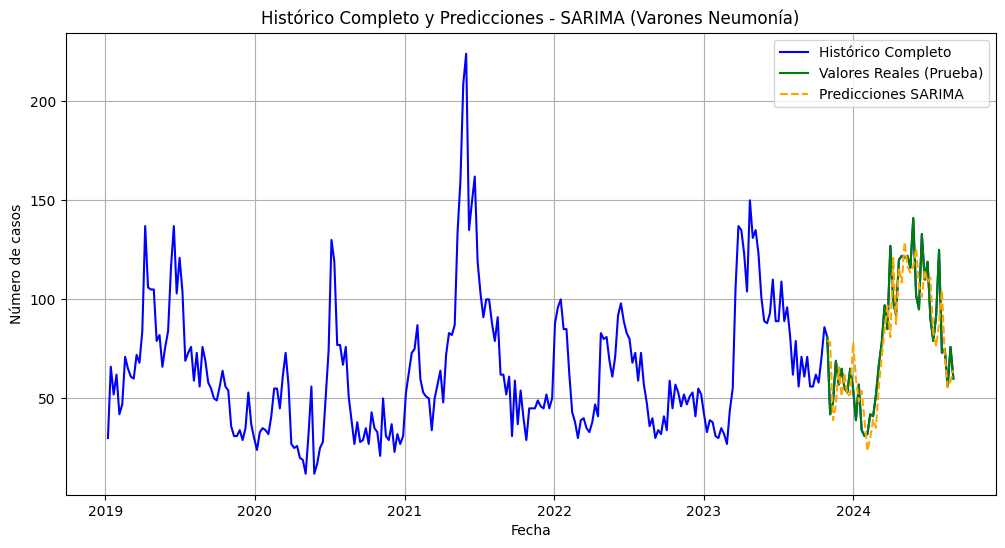

In [ ]:
# Graficar el histórico y las predicciones del modelo SARIMA
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_varones.index, data_neumonia_varones['varones'], label="Histórico Completo", color="blue")
plt.plot(test_neumonia_varones.index, y_true_sarima, label="Valores Reales (Prueba)", color="green")
plt.plot(test_neumonia_varones.index, y_pred_sarima, color='orange', linestyle='--', label="Predicciones SARIMA")
plt.title("Histórico Completo y Predicciones - SARIMA (Varones Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para SARIMA
comparison_df_sarima_neumonia_varones = pd.DataFrame({
    'Fecha': test_neumonia_varones.index,
    'Valores Reales': y_true_sarima,
    'Predicciones SARIMA': y_pred_sarima
})

# Mostrar el DataFrame comparativo
print(comparison_df_sarima_neumonia_varones)

        Fecha  Valores Reales  Predicciones SARIMA
0  2023-10-30              81            79.187157
1  2023-11-06              42            78.313409
2  2023-11-13              48            39.031354
3  2023-11-20              69            46.699702
4  2023-11-27              57            65.738301
5  2023-12-04              65            51.066763
6  2023-12-11              55            62.656898
7  2023-12-18              53            51.329643
8  2023-12-25              65            52.128839
9  2024-01-01              55            78.327931
10 2024-01-08              39            59.921066
11 2024-01-15              57            48.448121
12 2024-01-22              34            53.738181
13 2024-01-29              31            38.929916
14 2024-02-05              32            23.511242
15 2024-02-12              42            30.217611
16 2024-02-19              41            39.375186
17 2024-02-26              52            35.171071
18 2024-03-04              67  

                Fecha  Predicciones SARIMA  Limite inferior  Limite superior
2024-09-09 2024-09-08            61.928483        23.981945        99.875020
2024-09-16 2024-09-15            48.768153        -0.519004        98.055310
2024-09-23 2024-09-22            56.510083         0.945505       112.074662
2024-09-30 2024-09-29            48.792299       -10.582260       108.166858
2024-10-07 2024-10-06            61.458796        -0.320579       123.238172
2024-10-14 2024-10-13            54.726069        -8.602658       118.054796
2024-10-21 2024-10-20            60.234631        -4.104141       124.573404
2024-10-28 2024-10-27            57.907296        -7.094609       122.909202


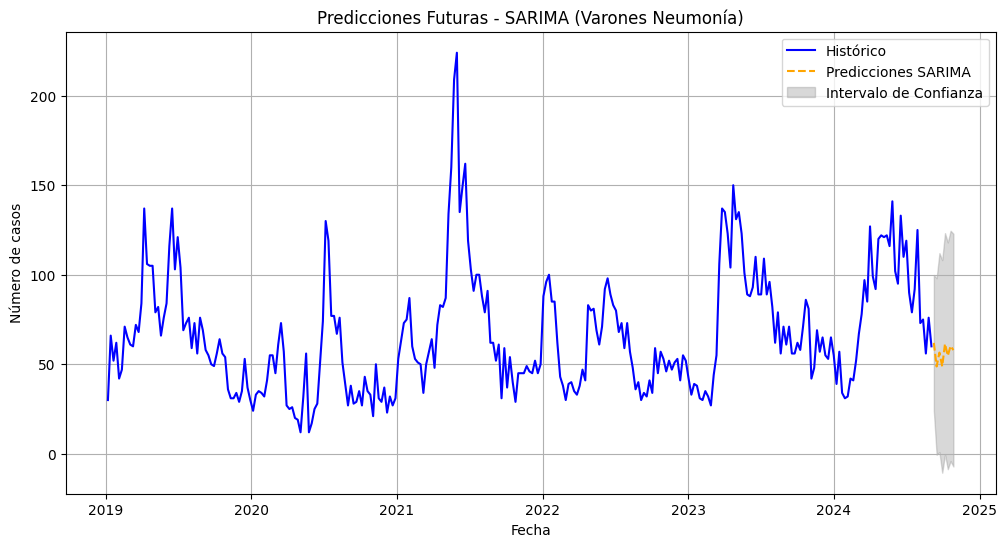

In [ ]:
# prompt: realiza 8 predicciones a futuro

# Realizar predicciones futuras con el modelo SARIMA (se asume que es el mejor modelo)
future_steps = 8
future_predictions = sarima_result_neumonia_varones.get_forecast(steps=future_steps)

# Obtener las predicciones y los intervalos de confianza
future_mean = future_predictions.predicted_mean
future_conf_int = future_predictions.conf_int()

# Crear un índice de fechas para las predicciones futuras
last_date = data_neumonia_varones.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='W')

# Crear un DataFrame para las predicciones futuras
future_df = pd.DataFrame({
    'Fecha': future_dates,
    'Predicciones SARIMA': future_mean,
    'Limite inferior': future_conf_int['lower varones'],
    'Limite superior': future_conf_int['upper varones']
})

# Mostrar las predicciones futuras
print(future_df)

# Graficar las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(data_neumonia_varones.index, data_neumonia_varones['varones'], label="Histórico", color="blue")
plt.plot(future_df['Fecha'], future_df['Predicciones SARIMA'], color='orange', linestyle='--', label="Predicciones SARIMA")
plt.fill_between(future_df['Fecha'], future_df['Limite inferior'], future_df['Limite superior'], color='gray', alpha=0.3, label='Intervalo de Confianza')
plt.title("Predicciones Futuras - SARIMA (Varones Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

                Fecha  Predicciones SARIMA  Valores Reales
2024-09-09 2024-09-08                 62.0              72
2024-09-16 2024-09-15                 49.0              58
2024-09-23 2024-09-22                 57.0              56
2024-09-30 2024-09-29                 49.0              56
2024-10-07 2024-10-06                 61.0              50
2024-10-14 2024-10-13                 55.0              59
2024-10-21 2024-10-20                 60.0              52
2024-10-28 2024-10-27                 58.0              48
MAE (futuro): 7.61
RMSE (futuro): 8.32
MAPE (futuro): 13.79%
sMAPE (futuro): 13.56%


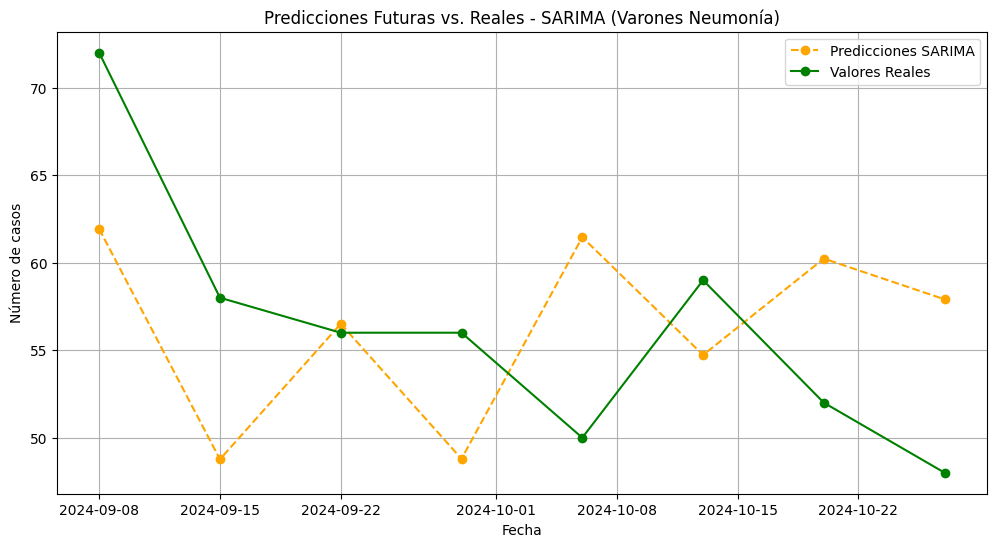

In [ ]:
# prompt: estos son los 8 valores reales, quiero que contrastes tu predicción con estos:
# 72
# 58
# 56
# 56
# 50
# 59
# 52
# 48

# Existing code ... (your provided code)

# Real values provided
real_values = [72, 58, 56, 56, 50, 59, 52, 48]

# Assuming 'future_df' is already created as in your provided code

# Create a DataFrame for the comparison
comparison_future_df = pd.DataFrame({
    'Fecha': future_df['Fecha'],
    'Predicciones SARIMA': future_df['Predicciones SARIMA'].round(),
    'Valores Reales': real_values
})

# Print the comparison DataFrame
print(comparison_future_df)


# Calculate metrics for future predictions
y_true_future = real_values
y_pred_future = future_df['Predicciones SARIMA'].values


mae_future = mean_absolute_error(y_true_future, y_pred_future)
rmse_future = np.sqrt(mean_squared_error(y_true_future, y_pred_future))
mape_future = mean_absolute_percentage_error(y_true_future, y_pred_future) * 100  # Convertir a porcentaje

smape_future = 100 * np.mean(2 * np.abs(y_true_future - y_pred_future) / (np.abs(y_true_future) + np.abs(y_pred_future)))

# Imprimir métricas de evaluación para predicciones futuras
print(f'MAE (futuro): {mae_future:.2f}')
print(f'RMSE (futuro): {rmse_future:.2f}')
print(f'MAPE (futuro): {mape_future:.2f}%')
print(f'sMAPE (futuro): {smape_future:.2f}%')


# Plot with real values
plt.figure(figsize=(12, 6))
#plt.plot(data_neumonia_varones.index, data_neumonia_varones['varones'], label="Histórico", color="blue")
plt.plot(future_df['Fecha'], future_df['Predicciones SARIMA'], color='orange', linestyle='--', marker='o', label="Predicciones SARIMA")
plt.plot(future_df['Fecha'], real_values, color='green', linestyle='-', marker='o', label="Valores Reales") # Plot real values
#plt.fill_between(future_df['Fecha'], future_df['Limite inferior'], future_df['Limite superior'], color='gray', alpha=0.3, label='Intervalo de Confianza')
plt.title("Predicciones Futuras vs. Reales - SARIMA (Varones Neumonía)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()